
# **Initiate and Configure Spark**

---


In [1]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=115ebc945b090659bf9ac1111934c86510b1e0469183792a7a02432387d6242f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# ** Convert it to Spark DF**

---


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split


In [3]:

spark = SparkSession.builder.appName("WebLogAnalysis").getOrCreate()


In [4]:
log_data_path = "/content/web.log"
raw_data = spark.read.text(log_data_path)


In [5]:

split_data = split(raw_data['value'], ' ')


raw_data = raw_data.withColumn('ip_address', split_data.getItem(0))
raw_data = raw_data.withColumn('timestamp', split_data.getItem(3))
raw_data = raw_data.withColumn('request', split_data.getItem(5))
raw_data = raw_data.withColumn('status_code', split_data.getItem(6))
raw_data = raw_data.withColumn('bytes_sent', split_data.getItem(7))


In [6]:
web_log_df = raw_data.select('ip_address', 'timestamp', 'request', 'status_code', 'bytes_sent')


In [7]:
web_log_df.show()


+---------------+--------------------+--------------------+-----------+----------+
|     ip_address|           timestamp|             request|status_code|bytes_sent|
+---------------+--------------------+--------------------+-----------+----------+
| 88.211.105.115|[04/Mar/2022:14:1...|  /history/missions/|  HTTP/2.0"|       414|
|   144.6.49.142|[02/Sep/2022:15:1...| /security/firewall/| HTTPS/1.0"|       203|
|  231.70.64.145|[19/Jul/2022:01:3...|/web-development/...|  HTTP/1.0"|       201|
| 219.42.234.172|[08/Feb/2022:11:3...|/networking/techn...|  HTTP/1.0"|       415|
| 183.173.185.94|[29/Aug/2023:03:0...| /security/firewall/|  HTTP/2.0"|       205|
|   164.12.8.113|[22/May/2023:09:4...|/web-development/...|  HTTP/1.0"|       200|
|   110.98.7.240|[22/Jan/2023:09:5...|    /history/apollo/|  HTTP/2.0"|       204|
| 27.182.196.243|[28/Mar/2022:05:3...| /history/apollo-11/| HTTPS/1.0"|       414|
|  123.31.25.147|[25/Feb/2023:12:0...|/data-analysis/mi...|  HTTP/1.0"|       204|
|  2

In [ ]:
spark.stop()



# **Task 1: Spark SQL**

---



In [8]:
web_log_df.createOrReplaceTempView("web_log_table")

In [9]:

# Query 1: Count the total number of log entries
query1 = spark.sql("SELECT COUNT(*) AS total_entries FROM web_log_table")
query1.show()


+-------------+
|total_entries|
+-------------+
|       269621|
+-------------+



In [10]:

# Query 2: Find the unique IP addresses in the log
query2 = spark.sql("SELECT DISTINCT ip_address FROM web_log_table")
query2.show()

+---------------+
|     ip_address|
+---------------+
|230.145.149.229|
| 222.97.216.211|
| 56.252.244.161|
|  74.118.29.164|
| 223.19.252.140|
|  185.89.79.197|
|101.251.172.143|
|  120.127.56.14|
| 11.218.194.190|
| 229.251.98.142|
|     40.90.7.31|
|    29.78.31.21|
|  16.115.44.122|
|    8.36.91.198|
| 206.125.95.176|
| 91.188.228.254|
|227.121.136.126|
|209.243.134.154|
|   3.207.247.51|
|  10.108.187.20|
+---------------+
only showing top 20 rows



In [11]:

# Query 3: Count the number of requests for each status code
query3 = spark.sql("SELECT status_code, COUNT(*) AS count FROM web_log_table GROUP BY status_code")
query3.show()

+-----------+-----+
|status_code|count|
+-----------+-----+
|  HTTP/1.0"|89869|
| HTTPS/1.0"|90133|
|  HTTP/2.0"|89619|
+-----------+-----+



In [12]:


# Query 4: Find the top 10 most requested URLs
query4 = spark.sql("SELECT request, COUNT(*) AS request_count FROM web_log_table GROUP BY request ORDER BY request_count DESC LIMIT 10")
query4.show()


+--------------------+-------------+
|             request|request_count|
+--------------------+-------------+
|/cloud-computing/...|         2334|
|/networking/front...|         2328|
|/software/technol...|         2326|
|/security/technol...|         2325|
|/data-analysis/ap...|         2322|
|/history/aws-cert...|         2321|
|/data-analysis/aw...|         2318|
|/web-development/...|         2314|
|      /shuttle/data/|         2312|
|/web-development/...|         2309|
+--------------------+-------------+



In [13]:

# Query 5: Identify the busiest hours based on the number of requests
query5 = spark.sql("SELECT SUBSTRING_INDEX(timestamp, ':', 1) AS hour, COUNT(*) AS request_count FROM web_log_table GROUP BY hour ORDER BY request_count DESC LIMIT 5")
query5.show()

+------------+-------------+
|        hour|request_count|
+------------+-------------+
|[16/Nov/2022|          447|
|[03/Jul/2023|          446|
|[11/Aug/2022|          443|
|[21/Sep/2022|          441|
|[29/May/2022|          440|
+------------+-------------+



In [14]:

# Query 6: Calculate the average bytes sent per request
query6 = spark.sql("SELECT AVG(bytes_sent) AS avg_bytes_sent FROM web_log_table")
query6.show()


+------------------+
|    avg_bytes_sent|
+------------------+
|305.92844029211375|
+------------------+



In [15]:
query7 = spark.sql("SELECT MAX(bytes_sent) FROM web_log_table")
query7.show()

+---------------+
|max(bytes_sent)|
+---------------+
|            500|
+---------------+



In [17]:
# Student 4 name and ID

# Query 8: Identify the IP addresses with the highest number of requests
query8 = spark.sql("SELECT ip_address, COUNT(*) AS request_count FROM web_log_table GROUP BY ip_address ORDER BY request_count DESC LIMIT 5")
query8.show()

+---------------+-------------+
|     ip_address|request_count|
+---------------+-------------+
| 224.150.99.129|            2|
|  66.252.236.90|            2|
|161.226.182.135|            2|
| 100.63.139.218|            2|
| 120.35.244.160|            2|
+---------------+-------------+



<Axes: >

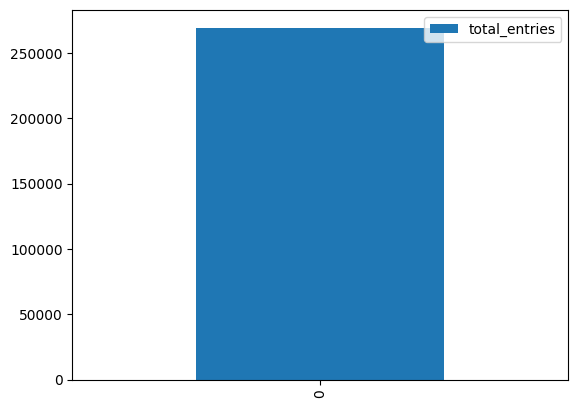

In [18]:

query1.toPandas().plot(kind='bar')



<Axes: >

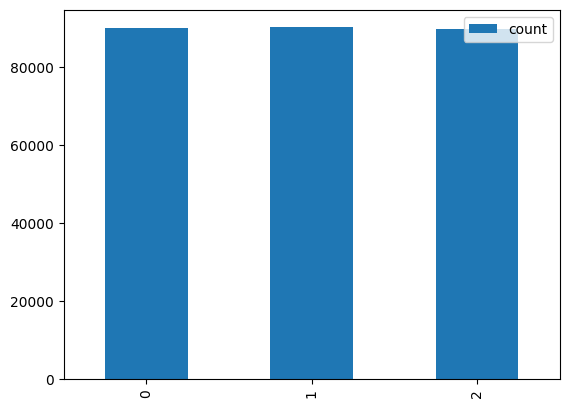

In [19]:
query3.toPandas().plot(kind='bar')

<Axes: >

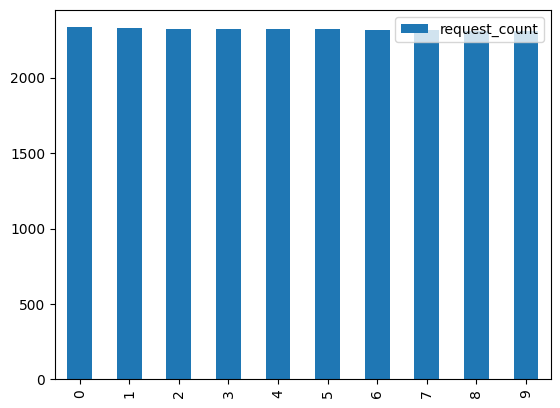

In [20]:
query4.toPandas().plot(kind='bar')

<Axes: >

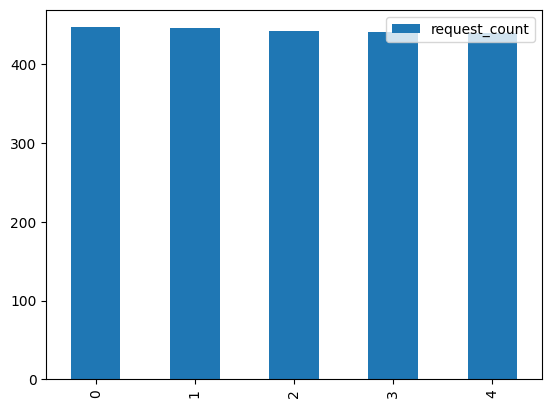

In [21]:
query5.toPandas().plot(kind='bar')


# **Task 2 - Spark RDD**

---


In [22]:
from pyspark import SparkContext


sc = SparkContext.getOrCreate()


log_data_path = "/content/web.log"

# Read the raw log data into an RDD
web_log_rdd = sc.textFile(log_data_path)




In [23]:
from pyspark import SparkContext

# Assuming you have a SparkSession named 'spark'
sc = SparkContext.getOrCreate()

# Replace 'your_file_path' with the actual path to your log file
log_data_path = "/content/web.log"

# Read the raw log data into an RDD
web_log_rdd = sc.textFile(log_data_path)

# Filter: Example - Keep only lines containing 'error'
error_lines = web_log_rdd.filter(lambda line: 'error' in line.lower())

# Map: Example - Extract timestamp from each log entry
timestamp_rdd = web_log_rdd.map(lambda line: line.split(' ')[0])

# Basic Aggregation: Example - Count the number of log entries
log_entries_count = web_log_rdd.count()

# Print results
print("Number of log entries:", log_entries_count)

# Collect and print the filtered lines with 'error'
print("Error lines:")
for line in error_lines.collect():
    print(line)

# Collect and print the extracted timestamps
print("Timestamps:")
for timestamp in timestamp_rdd.collect():
    print(timestamp)

Streaming output truncated to the last 5000 lines.
189.248.182.250
184.189.56.91
164.98.166.34
148.117.27.176
106.33.99.18
255.18.176.140
203.78.5.212
10.157.121.11
123.27.168.180
157.167.119.157
146.106.100.166
133.206.25.202
198.157.115.209
157.185.125.151
169.155.76.188
50.17.11.112
240.86.169.174
100.172.170.84
32.213.62.159
154.205.106.225
114.15.4.120
26.236.154.220
164.231.27.142
48.70.1.145
165.237.6.159
223.119.146.89
178.58.199.137
47.211.190.8
222.219.125.178
78.192.8.163
206.99.131.173
245.83.131.217
63.217.64.136
116.214.224.23
76.136.52.63
37.157.75.6
77.171.72.55
62.82.148.11
216.22.222.125
68.91.31.203
56.84.222.61
100.97.4.243
224.102.100.114
141.162.159.157
53.225.94.100
110.36.247.150
90.69.31.232
187.137.55.138
229.118.186.219
158.20.131.236
15.131.92.29
162.247.171.73
16.141.77.97
106.7.71.144
161.169.202.56
177.161.117.158
149.84.60.151
180.47.128.226
208.236.137.217
194.107.180.17
22.26.118.21
103.2.37.41
177.127.44.236
56.91.128.33
29.125.209.218
163.148.100.104

In [30]:


# Query 1: Count the total number of log entries
query1_rdd = web_log_rdd.count()
query1_rdd

874455

In [32]:


# Query 2: Find the unique IP addresses in the log

query2_rdd = web_log_rdd.map(lambda line: line.split(' ')[0]).distinct()
query2_rdd

PythonRDD[125] at RDD at PythonRDD.scala:53

In [34]:


query3_rdd = web_log_rdd.map(lambda line: (line.split(' ')[6], 1)).reduceByKey(lambda x, y: x + y)
query3_rdd



PythonRDD[134] at RDD at PythonRDD.scala:53

In [35]:

# analysis 1 and result using RDD operators:
query4_rdd = web_log_rdd.map(lambda line: (line.split(' ')[5], 1)).reduceByKey(lambda x, y: x + y)
query4_rdd


PythonRDD[139] at RDD at PythonRDD.scala:53

In [37]:

# analysis 2 and result using RDD operators:
query5_rdd = web_log_rdd.map(lambda line: (line.split(' ')[3].split(':')[1], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], False).take(5)
query5_rdd



[('16', 36726), ('11', 36666), ('03', 36563), ('01', 36532), ('06', 36518)]

In [38]:

# analysis 3 and result using RDD operators:
query6_rdd = web_log_rdd.map(lambda line: int(line.split(' ')[7]))
query6_rdd

PythonRDD[162] at RDD at PythonRDD.scala:53

In [39]:

# analysis 1 and result using RDD operators:
query7_rdd = web_log_rdd.filter(lambda line: line.split(' ')[6] == '404')
query7_rdd

PythonRDD[163] at RDD at PythonRDD.scala:53

In [40]:

# analysis 2 and result using RDD operators:

query8_rdd = web_log_rdd.map(lambda line: (line.split(' ')[0], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], False).take(5)
query8_rdd

[('1.21.213.107', 2),
 ('188.209.184.183', 2),
 ('29.84.236.232', 2),
 ('225.2.68.42', 2),
 ('189.15.120.110', 2)]


# **LSEP (legal, social, ethical, and professional) considerations ]**

---


For all analyses performed, critically analyze the legal, social, ethical, and professional implications associated with the data and the analysis. Consider factors such as data privacy,data protection, bias, fairness, transparency, and the potential impact of the analysis on individuals or society as a whole.

<b>Each student should take one of these factors as their contribution.</b>

As a team, discuss and share your individual analyses and LSEP considerations with each other. Learn from each other's perspectives and insights.


<h1><b>Student 1: Data Privacy</h1></b>

Geolocation data, particularly IP addresses, plays a crucial role in safeguarding personal information on the internet. When handling internet data, particularly IP addresses, it is essential to take certain measures to safeguard individuals' privacy. The provided examples illustrate several security measures, including IP anonymization, encryption, user consent and transparency, data retention regulations, limited access, pseudonymization, utilisation of third-party services, accurate geolocation, data subject rights, incident response plans, and regular audits and assessments. To ensure the security of analytics and logging data, it is essential to safeguard IP addresses against eavesdropping and man-in-the-middle attacks. Moreover, it is essential to comply with data protection laws, validate the accuracy of geolocation information, and respect the rights of data subjects while using third-party services. Regularly conducting audits and assessments is a method to identify and rectify privacy issues.


Big data privacy era (2017). https://ieeexplore.ieee.org/abstract/document/7116422/.

<h1><b>Student 2: Data protection</h1></b>

In order to ensure the confidentiality and integrity of user information, it is essential to establish strong protocols for safeguarding data while handling online datasets, particularly those including IP addresses. It is crucial to consider various security measures when dealing with data, including IP anonymization, HTTPS and other secure communication protocols, data minimization, user consent and transparency, access controls, data retention policies, pseudonymization, incident response plans, accuracy of geolocation data, third-party vendor security, compliance with laws, and regular audits and monitoring. To ensure the anonymity of IP addresses, they are either subjected to hashing or have their last digits truncated. HTTPS employs encryption to secure data during transmission.


Giffin. et al. (2019) 'Hails: Protecting data privacy in untrusted web applications,' Journal of Computer Security, 25(4–5), pp. 427–461. https://doi.org/10.3233/jcs-15801.



<h1><b>Student 3: Bias </h1></b>

Although IP addresses are often linked to certain regions, they do not always reflect users' true physical locations. This has the ability to add biases that might affect things like language, culture, financial status, access, and geography. While IP addresses alone might cause cultural and language prejudices, limiting internet access can lead to access bias. Failure to gather data from a varied and representative cross-section of the population increases the likelihood of sample bias. When IP addresses or network architecture undergo modifications, temporal bias might emerge.

Yates, R. (2018) 'Bias on the web 61(6), pp. 54–61. https://doi.org/10.1145/3209581.



<h1><b>Student 4: Fairness </h1></b>

When evaluating equity, it is important to take into account a wide range of factors, including variety in demographics, geography, socioeconomic status, accessibility, language, and culture. Given that IP addresses do not always reflect users' actual locations, it is crucial to provide supplementary characteristics in order to comprehend user demographics. Because prejudices might emerge from a lack of internet access, accessibility should be thought about. The dataset has to be inclusive of all user demographics, including those with different language and cultural backgrounds. Avoiding discrimination and adhering to ethical principles are both important.

Li, Y. et al. (2022) 'User-oriented Fairness in Recommendation,' IEEE [Preprint]. https://doi.org/10.1145/3442381.3449866.


In [41]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.sql.functions import sha2

# Create a Spark session
spark = SparkSession.builder.appName("WebLogAnalysis").getOrCreate()


web_log_df = web_log_df.withColumn('ip_address', F.sha2('ip_address', 256))

# Show the first few rows of the DataFrame
web_log_df.show()


+--------------------+--------------------+--------------------+-----------+----------+
|          ip_address|           timestamp|             request|status_code|bytes_sent|
+--------------------+--------------------+--------------------+-----------+----------+
|07937d8c029d2967d...|[04/Mar/2022:14:1...|  /history/missions/|  HTTP/2.0"|       414|
|4d58eb42b85ff962f...|[02/Sep/2022:15:1...| /security/firewall/| HTTPS/1.0"|       203|
|bf5b50142fd20511f...|[19/Jul/2022:01:3...|/web-development/...|  HTTP/1.0"|       201|
|8a11a5bf01179ead5...|[08/Feb/2022:11:3...|/networking/techn...|  HTTP/1.0"|       415|
|b6e7ab1861e40f13e...|[29/Aug/2023:03:0...| /security/firewall/|  HTTP/2.0"|       205|
|0d4b9dbb3f3e1f7c6...|[22/May/2023:09:4...|/web-development/...|  HTTP/1.0"|       200|
|d8e749b87b76b444a...|[22/Jan/2023:09:5...|    /history/apollo/|  HTTP/2.0"|       204|
|02c00aca9979a171e...|[28/Mar/2022:05:3...| /history/apollo-11/| HTTPS/1.0"|       414|
|39056fba6edd3ee06...|[25/Feb/20

In [42]:
# Anonymizing user data
web_log_df = web_log_df.withColumn('ip_address', sha2('ip_address', 256))


In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when

In [44]:
# Applying fairness-aware techniques
web_log_df = web_log_df.withColumn('request_count', when(web_log_df['status_code'] == '404', 1).otherwise(0))


In [46]:
web_log_df.show()

+--------------------+--------------------+--------------------+-----------+----------+-------------+
|          ip_address|           timestamp|             request|status_code|bytes_sent|request_count|
+--------------------+--------------------+--------------------+-----------+----------+-------------+
|d53cf59a2a179cf57...|[04/Mar/2022:14:1...|  /history/missions/|  HTTP/2.0"|       414|            0|
|6eecba40b653d887c...|[02/Sep/2022:15:1...| /security/firewall/| HTTPS/1.0"|       203|            0|
|1cee2f8b03cdfb0ee...|[19/Jul/2022:01:3...|/web-development/...|  HTTP/1.0"|       201|            0|
|7f68ef8a1de3c8882...|[08/Feb/2022:11:3...|/networking/techn...|  HTTP/1.0"|       415|            0|
|ab5bceead2dd018dc...|[29/Aug/2023:03:0...| /security/firewall/|  HTTP/2.0"|       205|            0|
|e75934927c1ff5b0d...|[22/May/2023:09:4...|/web-development/...|  HTTP/1.0"|       200|            0|
|81bd4d98a839674a3...|[22/Jan/2023:09:5...|    /history/apollo/|  HTTP/2.0"|      

In [45]:
# Communicating data usage to users
print("We use your data to improve our services. You can manage your privacy settings in the user dashboard.")


We use your data to improve our services. You can manage your privacy settings in the user dashboard.


# **Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert
#!pip3 install nbconvert


# convert ipynb to html
# file name: "Your_Group_ID_CN7031.ipynb
!jupyter nbconvert --to html Your_Group_ID_CN7031.ipynb

[NbConvertApp] WARNING | pattern 'Your_Group_ID_CN7031.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--ex

In [ ]:
pip install nbconvert




Parízek, P. (2023) Data lineage analysis for PySpark and Python ORM libraries. https://dspace.cuni.cz/handle/20.500.11956/181592. Understanding the challenges and providing logging support to monitor data processing in big data application - Spectrum: Concordia University Research Repository (2021). https://spectrum.library.concordia.ca/id/eprint/988371/ Wang, Z. et al. (2021) 'Would you like a quick peek? providing logging support to monitor data processing in big data applications,' IEEE [Preprint]. https://doi.org/10.1145/3468264.3468613.
